# MLP Batch Normalization

A batch normalization implementation with manually calculated gradients.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib notebook

## 1. Define Model

In this simple implementation, all hidden layer activation functions are ReLu, output activation function is Softmax.

In [2]:
NUMERICAL_EPSILON = 1e-8

In [3]:
def xavier_weight_initialization(last_layer_size, next_layer_size, activation='relu'):
    variance = 2 if activation == 'relu' else 1
    scalar = math.sqrt(variance/(last_layer_size + next_layer_size))
    return np.random.randn(last_layer_size, next_layer_size).astype(np.float32) * scalar

In [4]:
def init_parameters(input_size, layer_size, output_size):
    layer_size = list(layer_size)
    layer_size.insert(0, input_size)
    layer_size.append(output_size)
    result = {}
    for i in range(len(layer_size) - 1):
        idx_str = str(i)
        result['w' + idx_str] = xavier_weight_initialization(layer_size[i], layer_size[i + 1])
        result['scalar' + idx_str] = np.ones(shape=(1, layer_size[i + 1]), dtype=np.float32)
        result['bias' + idx_str] = np.zeros(shape=(1, layer_size[i + 1]), dtype=np.float32)
    return result

In [5]:
def forward_prop(X, params, mean_std_dict=None):
    neurons = X
    num_layer = len(params) // 3
    cache = {}
    for i in range(num_layer):
        idx_str = str(i)
        W = params['w' + str(i)]
        bn_scalar = params['scalar' + str(i)]
        bn_bias = params['bias' + str(i)]
        linear_values = neurons @ W
        if mean_std_dict is None:
            mean = np.mean(linear_values, axis=0, keepdims=True)
            variance = np.var(linear_values, axis=0, keepdims=True)
            std = np.sqrt(variance + NUMERICAL_EPSILON)
        else:
            mean = mean_std_dict['mean' + idx_str]
            std = mean_std_dict['std' + idx_str]
        linear_values_std_normalized = (linear_values - mean)/std
        linear_values_normalized = bn_scalar * linear_values_std_normalized + bn_bias
        if i < num_layer - 1:
            activation_values = linear_values_normalized * (linear_values_normalized > 0)
        else:
            e_power = np.exp(linear_values_normalized)
            e_power_sum = np.sum(e_power, axis=1, keepdims=True)
            activation_values = e_power/e_power_sum
        neurons = activation_values
        cache['z' + idx_str] = linear_values
        cache['mean' + idx_str] = mean
        cache['std' + idx_str] = std
        cache['z_1_' + idx_str] = linear_values_std_normalized
        cache['z_2_' + idx_str] = linear_values_normalized
        cache['a' + idx_str] = neurons
    return neurons, cache

In [6]:
def back_prop(X, Y, params, cache):
    m = X.shape[0]
    num_layer = len(params) // 3
    gradients = {}
    dz_next_layer = None
    for i in range(num_layer)[::-1]:
        idx_str = str(i)
        if i == num_layer - 1:
            dz2 = cache['a' + idx_str] - Y
        else:
            dz_next_layer_da = params['w' + str(i + 1)]
            da_dz2 = np.ones(shape=cache['z_2_' + idx_str].shape).astype(np.float32) * (cache['a' + idx_str] > 0)
            dz2 = da_dz2 * (dz_next_layer @ dz_next_layer_da.T)
        assert(dz2.shape == cache['z_2_' + idx_str].shape)
        
        gradients['dscalar' + idx_str] = np.sum(cache['z_1_' + idx_str] * dz2, axis=0, keepdims=True)/m
        assert(gradients['dscalar' + idx_str].shape == params['scalar' + idx_str].shape)
        
        gradients['dbias' + idx_str] = np.sum(dz2, axis=0, keepdims=True)/m
        assert(gradients['dbias' + idx_str].shape == params['bias' + idx_str].shape)
        
        # dl/dz from BN paper (Sergey Ioffee, Christian Szegedy):
        one_over_std = 1 / np.sqrt(cache['std' + idx_str] ** 2 + NUMERICAL_EPSILON)
        dz1 = dz2 * params['scalar' + idx_str]
        z_shifted = cache['z' + idx_str] - cache['mean' + idx_str]
        variance_term = -1/2 * np.power(cache['std' + idx_str] ** 2 + NUMERICAL_EPSILON, -3/2)
        dvariance = np.sum(dz1 * z_shifted * variance_term, axis=0, keepdims=True)
        dmean_bn = np.sum(dz1 * -1 * one_over_std, axis=0, keepdims=True)/m
        dmean_bn += dvariance * np.sum(-2 * (cache['z' + idx_str] - cache['mean' + idx_str]))/m
        dz = dz1 * one_over_std + dvariance * 2 * (cache['z' + idx_str] - cache['mean' + idx_str])/m + dmean_bn / m
        assert(cache['z' + idx_str].shape == dz.shape)
        
        # dl/dz derived by myself (wrong):
#         dz1 = params['scalar' + idx_str] * dz2
#         dz = 1/(cache['std' + idx_str] + NUMERICAL_EPSILON) * dz1

        last_activation_values = X if i == 0 else cache['a' + str(i - 1)]        
        gradients['dw' + idx_str] = last_activation_values.T @ dz
        assert(gradients['dw' + idx_str].shape == params['w' + idx_str].shape)
        
        dz_next_layer = dz
    return gradients

In [7]:
def update_parameters(params, gradients, learning_rate, adam_cache=None, momentum=0.9, rms_prop=0.99):
    if adam_cache is None:
        adam_cache = {'epoch': 0}
        for key, value in params.items():
            adam_cache['velocity_' + key] = np.zeros(shape=value.shape, dtype=np.float32)
            adam_cache['scale_' + key] = np.zeros(shape=value.shape, dtype=np.float32)
    adam_cache['epoch'] += 1
    num_iter = adam_cache['epoch']
    for key, value in params.items():
        adam_cache['velocity_' + key] = momentum * adam_cache['velocity_' + key] + (1 - momentum) * gradients['d' + key]
        adam_cache['velocity_' + key] /= (1 - momentum ** (num_iter + 1))
        adam_cache['scale_' + key] = rms_prop * adam_cache['scale_' + key] + (1 - rms_prop) * (gradients['d' + key] ** 2)
        adam_cache['scale_' + key] /= (1 - rms_prop ** (num_iter + 1))
        params[key] = params[key] - learning_rate * adam_cache['velocity_' + key] / (np.sqrt(adam_cache['scale_' + key]) + NUMERICAL_EPSILON)
#         params[key] = params[key] - learning_rate * gradients['d' + key]
    return params, adam_cache

## 2. Prepare Data

In [8]:
num_samples = 1000000
all_data = np.random.randn(num_samples, 4)
all_data[:, 2] = 0
all_data[:, 3] = 1
mean = np.mean(all_data[:, :2], axis=0, keepdims=True)
all_data[:, :2] -= mean

In [9]:
all_data_radius = np.sqrt(all_data[:, 0] ** 2 + all_data[:, 1] ** 2)
radius_mean = np.mean(all_data_radius)
lt_mean_mask = all_data_radius < radius_mean

In [10]:
all_data[lt_mean_mask, 2] = 1
all_data[lt_mean_mask, 3] = 0

In [11]:
dev_test_size = 5000
len_all_data = np.size(all_data, axis=0)
train = all_data[:len_all_data - 2 * dev_test_size]
dev = all_data[len_all_data - 2 * dev_test_size:len_all_data - 1 * dev_test_size]
test = all_data[len_all_data - 1 * dev_test_size:]

In [12]:
train_x, train_y = train[:, :2], train[:, 2:]
dev_x, dev_y = dev[:, :2], dev[:, 2:]
test_x, test_y = test[:, :2], test[:, 2:]
data = (train_x, train_y, dev_x, dev_y, test_x, test_y)

In [13]:
plt.figure(figsize=(8, 8))
lt_mean_x = all_data[lt_mean_mask, 0][:500]
lt_mean_y = all_data[lt_mean_mask, 1][:500]
gteq_mean_x = all_data[~lt_mean_mask, 0][:500]
gteq_mean_y = all_data[~lt_mean_mask, 1][:500]
plt.scatter(lt_mean_x, lt_mean_y)
plt.scatter(gteq_mean_x, gteq_mean_y)

<IPython.core.display.Javascript object>

## 3. Train Model

In [14]:
def loss(prediction, output):
    m = prediction.shape[0]
    return np.sum(np.abs(prediction - output)) / (2 * m)

In [15]:
def accuracy(prediction, output):
    m = prediction.shape[0]
    prediction_idx = np.argmax(prediction, axis=1).flatten()
    output_idx = np.argmax(output, axis=1).flatten()
    return np.count_nonzero(prediction_idx == output_idx) / m

In [16]:
def plot_and_print(loss_lst, accuracy_lst, fig, loss_axis, accuracy_axis, print_interval=100):
    if print_interval is not None and len(loss_lst) % print_interval == 0:
        print('Train/Dev/Test loss:\n{0}\n{1}\n{2}'.format(*loss_lst[-1]))
        print('Train/Dev/Test accuracy:\n{0}\n{1}\n{2}'.format(*accuracy_lst[-1]))
    
    colors=['r', 'g', 'b', 'c', 'm', 'k']
    
    train_loss = [ele[0] for ele in loss_lst]
    dev_loss = [ele[1] for ele in loss_lst]
    test_loss = [ele[2] for ele in loss_lst]
    
    train_accuracy = [ele[0] for ele in accuracy_lst]
    dev_accuracy = [ele[1] for ele in accuracy_lst]
    test_accuracy = [ele[2] for ele in accuracy_lst]
    
    num_epochs = len(train_loss)
    x = np.arange(num_epochs)
    
    train_loss_line, = loss_axis.plot(x, train_loss, label='Training Loss', color=colors[0])
    dev_loss_line, = loss_axis.plot(x, dev_loss, label='Dev Loss', color=colors[1])
    test_loss_line, = loss_axis.plot(x, test_loss, label='Test Loss', color=colors[2])
    
    train_accuracy_line, = accuracy_axis.plot(x, train_accuracy, label='Training Accuracy', color=colors[3])
    dev_accuracy_line, = accuracy_axis.plot(x, dev_accuracy, label='Dev Accuracy', color=colors[4])
    test_accuracy_line, = accuracy_axis.plot(x, test_accuracy, label='Test Accuracy', color=colors[5])

    loss_axis.legend((train_loss_line, dev_loss_line, test_loss_line), ('Training Loss', 'Dev Loss', 'Test Loss'))
    accuracy_axis.legend(
        (train_accuracy_line, dev_accuracy_line, test_accuracy_line),
        ('Training Accuracy', 'Dev Accuracy', 'Test Accuracy')
    )
    
    fig.canvas.draw()
    plt.show()

In [17]:
def fit(data, learning_rate, num_epoch, layer_sizes, momentum=0.9, rms_prop=0.98, mini_batch_size=100):
    train_x, train_y, dev_x, dev_y, test_x, test_y = data
    epoch_idx = 0
    
    num_features = train_x.shape[1]
    num_output = train_y.shape[1]
    train_size = train_x.shape[0]
    num_iter_per_epoch = train_size // mini_batch_size
    
    params = init_parameters(num_features, layer_sizes, num_output)
    adam_cache = None
    
    loss_lst = []
    accuracy_lst = []
    
    fig, (loss_axis, accuracy_axis) = plt.subplots(1, 2, figsize=(16, 9))
    
    accuracy_axis.set_ylim([0, 1])
    
    mean_std_dict = None
    iter_count = 0
    
    while iter_count < num_iter_per_epoch * num_epoch:
        batch_start_idx = iter_count % num_iter_per_epoch
        batch_end_idx = batch_start_idx + mini_batch_size
        mini_batch_x, mini_batch_y = train_x[batch_start_idx:batch_end_idx], train_y[batch_start_idx:batch_end_idx]
        output, cache = forward_prop(mini_batch_x, params)
        gradients = back_prop(mini_batch_x, mini_batch_y, params, cache)
        params, adam_cache = update_parameters(params, gradients, learning_rate, adam_cache, momentum, rms_prop)

        if mean_std_dict is None:
            mean_std_dict = {}
            for key, value in cache.items():
                if 'mean' in key or 'std' in key:
                    mean_std_dict[key] = cache[key]
        else:
            for key, value in cache.items():
                if 'mean' in key or 'std' in key:
                    last_val = mean_std_dict[key]
                    new_val = cache[key]
                    mean_std_dict[key] = (last_val * iter_count + new_val) / (iter_count + 1)
            
        iter_count += 1
        
        num_epoch_completed = iter_count // num_iter_per_epoch
        if num_epoch_completed > epoch_idx:
            train_prediction, _ = forward_prop(mini_batch_x, params, mean_std_dict)
            dev_prediction, _ = forward_prop(dev_x, params, mean_std_dict)
            test_prediction, _ = forward_prop(test_x, params, mean_std_dict)
            
            loss_lst.append((
                loss(train_prediction, mini_batch_y),
                loss(dev_prediction, dev_y),
                loss(test_prediction, test_y)
            ))
            
            accuracy_lst.append((
                accuracy(train_prediction, mini_batch_y),
                accuracy(dev_prediction, dev_y),
                accuracy(test_prediction, test_y)
            ))

            plot_and_print(loss_lst, accuracy_lst, fig, loss_axis, accuracy_axis)
            
            epoch_idx += 1
        
    return params, mean_std_dict

<IPython.core.display.Javascript object>


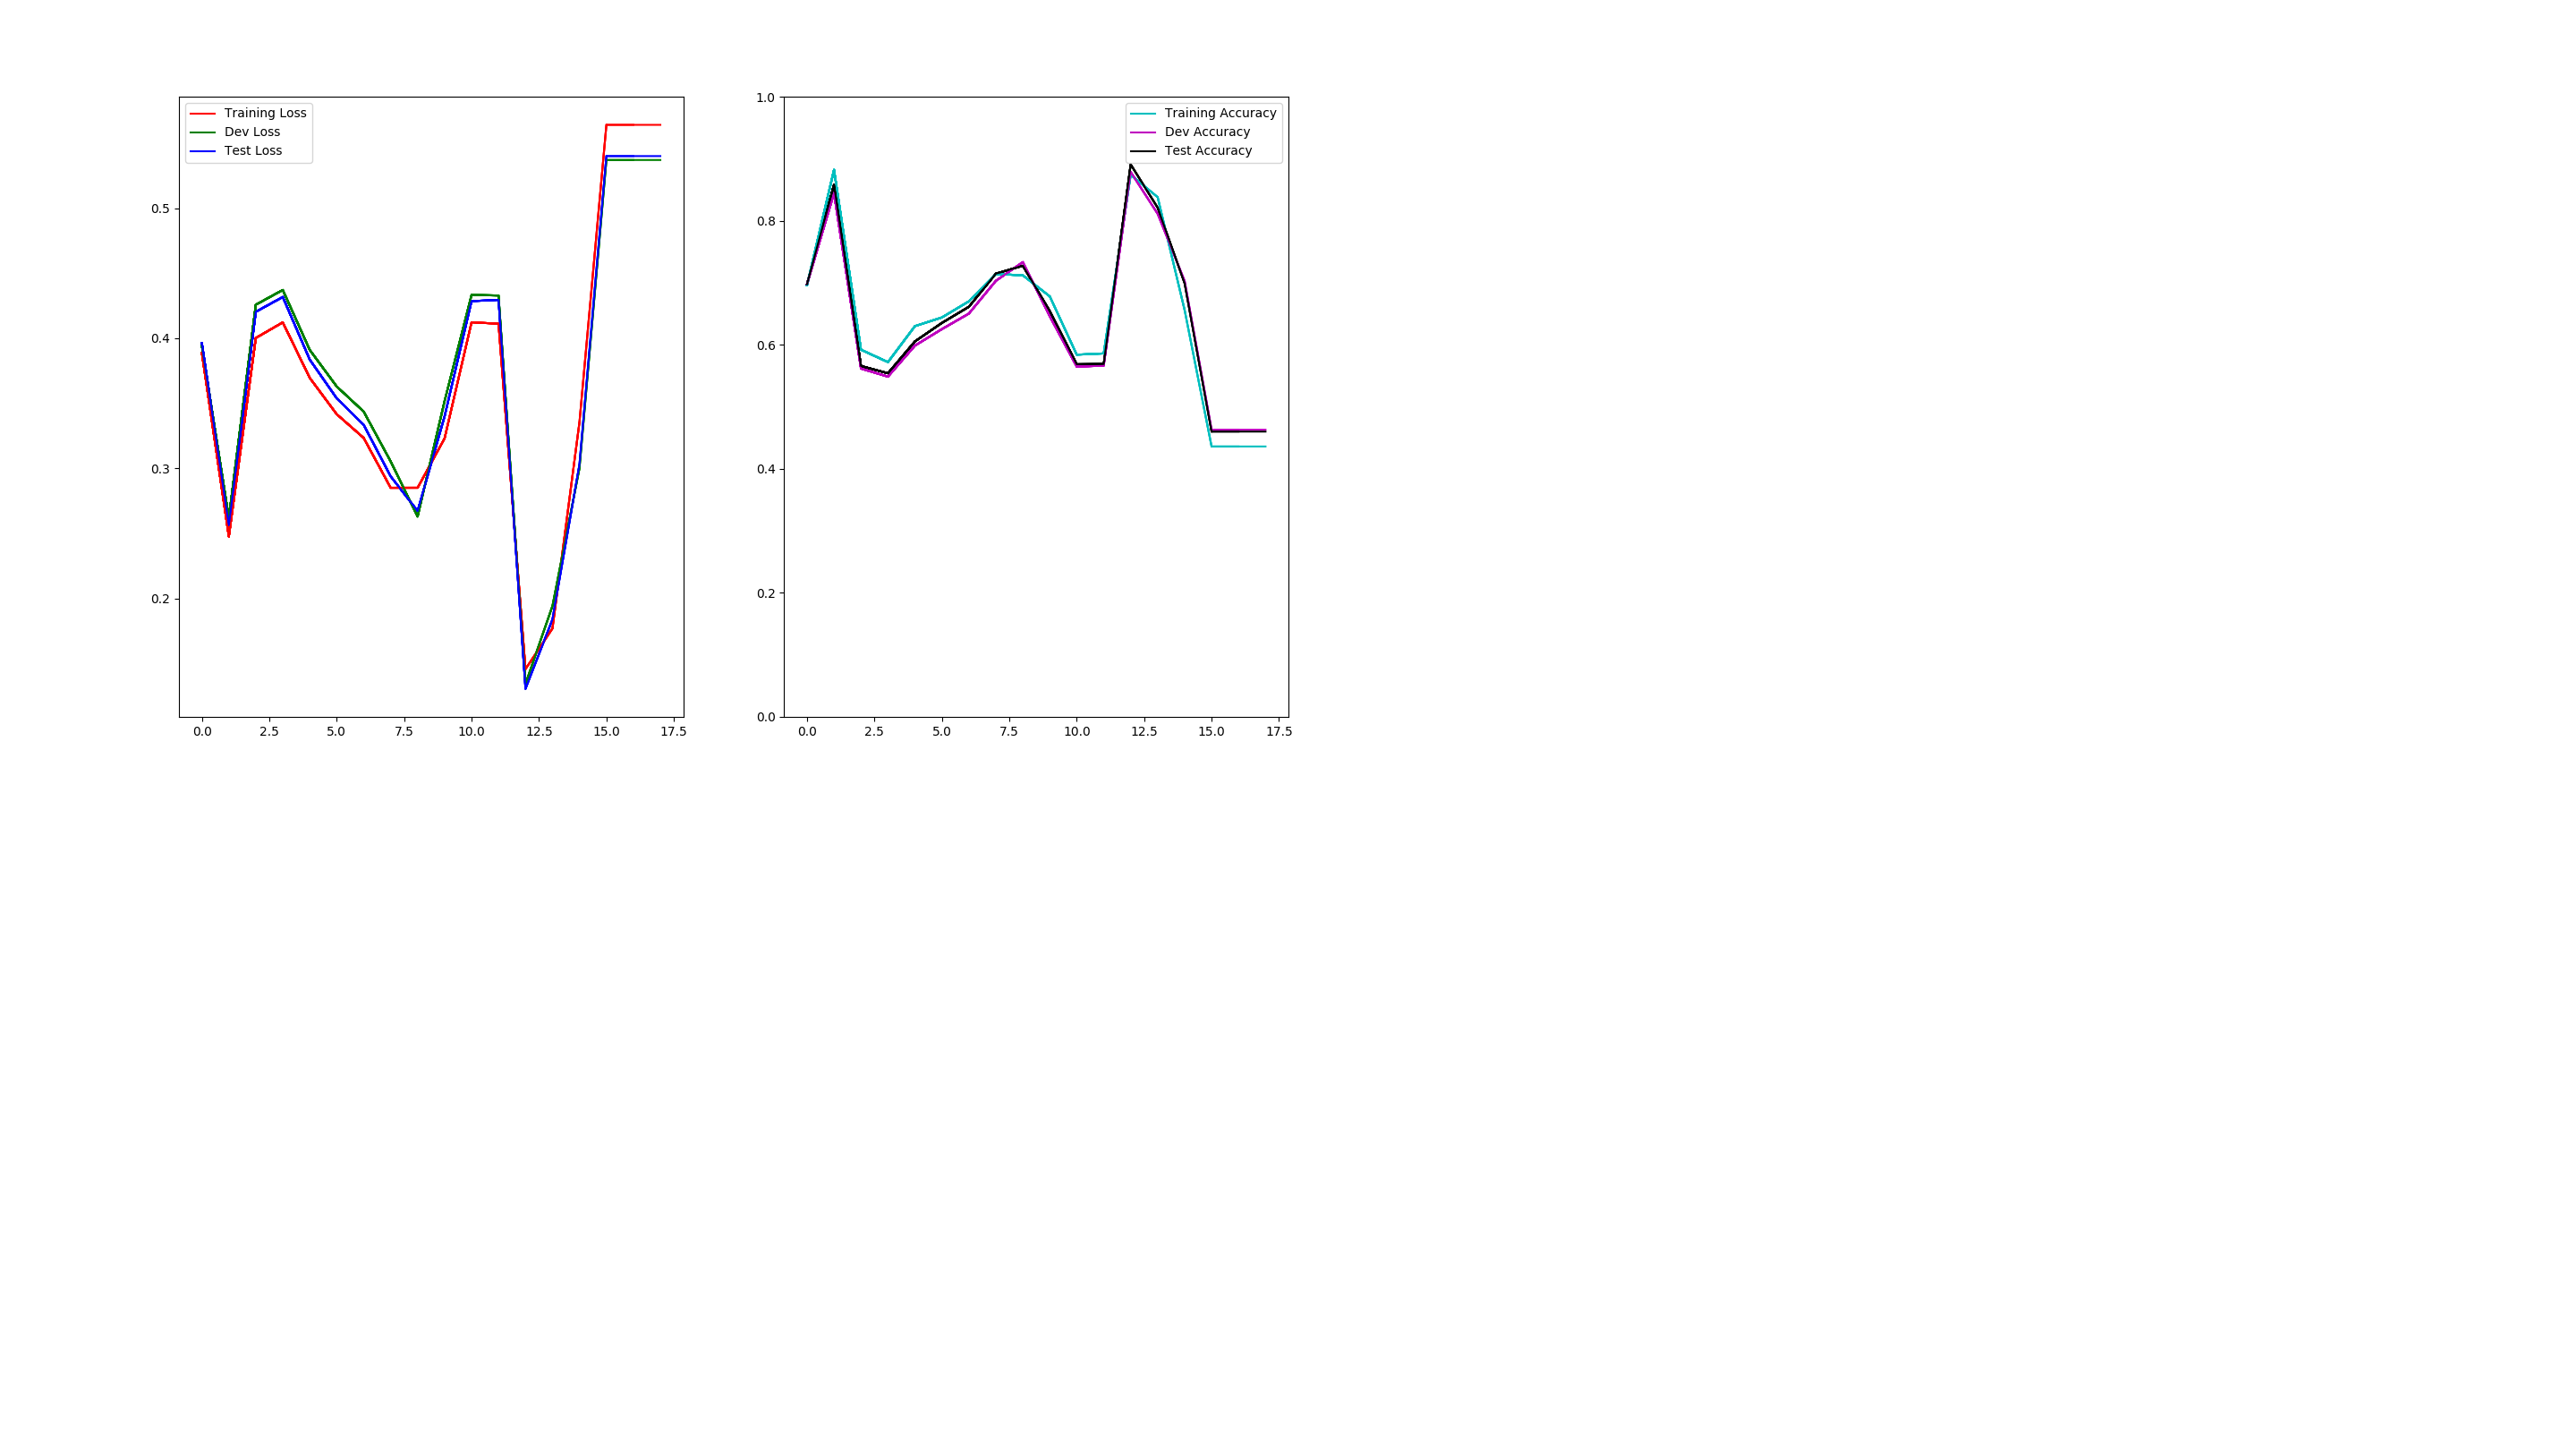

KeyboardInterrupt: 

In [18]:
params, mean_std_dict = fit(
    data=data,
    learning_rate=0.0001,
    num_epoch=150,
    layer_sizes=[8, 8],
    momentum=0.9,
    rms_prop=0.98,
    mini_batch_size=500
)